In [176]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
%matplotlib inline

# two versions, one with the training dataset, other with validation
cifar_path = r"C:\Users\DomagalaMa\Desktop\DLWP_notes\DLWP_notes\data\CIFAR10"
cifar10 = datasets.CIFAR10(cifar_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(cifar_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [177]:
len(cifar10)

50000

<PIL.Image.Image image mode=RGB size=32x32 at 0x1F8277B8080>


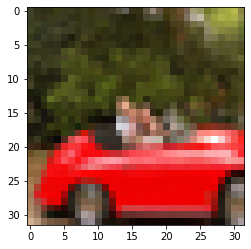

In [178]:
image, *_ = cifar10[99] #interested only in first value, the PIL image object
print(image)
plt.imshow(image)
plt.show()

In [179]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(image)
print(img_t.shape) #notice it's already in pytorch way - CxHxW

#now load whole dataset with already transform to tensor

tensor_cifar10 = datasets.CIFAR10(cifar_path, download=True, train=True, transform = transforms.ToTensor())

img_t, *_ = tensor_cifar10[99]

torch.Size([3, 32, 32])
Files already downloaded and verified


In [180]:
img_t.shape, img_t.dtype  #already in float32

(torch.Size([3, 32, 32]), torch.float32)

In [182]:
#normalizing the data part
#we will calculate the parameters for normalization step


#first, all of the data (50000 tensors) along new dimension
imgs = torch.stack([img for img, *_ in tensor_cifar10], dim=3)

In [183]:
imgs.view(3, -1).shape

torch.Size([3, 51200000])

In [184]:
mean_c = imgs.view(3, -1).mean(dim=1)
print(mean_c)

tensor([0.4915, 0.4823, 0.4468])


In [185]:
#mean calculated, now standard deviation
std_c = imgs.view(3, -1).std(dim=1)
print(std_c)

tensor([0.2470, 0.2435, 0.2616])


In [ ]:
#loading cifar once more, now with normalization

#values from previous calculations
mean = (0.4915, 0.4823, 0.4468)
std = (0.2470, 0.2435, 0.2616)

#loading with transform
new_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
transformed_cifar10 = datasets.CIFAR10(cifar_path, 
                                       download=True, 
                                       train=True, 
                                       transform = new_transform)

In [ ]:
img_new, *_ = transformed_cifar10[99]
plt.imshow(img_new.permute(1,2,0))

In [ ]:
#creating a model on only birds and airplanes
#create a cifar10 subset called cifar2 with only these two types of labels included
#notice that airplane - label 0, bird - label 2.
#we will transfer bird to be label 1 in the newly created dataset

label_mapping = {0:0, 2:1}

cifar2 = [(image, label_mapping[label]) for (image, label) in transformed_cifar10 if (label in [0,2])]
cifar2_val = [(image, label_mapping[label]) for (image, label) in transformed_cifar10 if (label in [0,2])]
len(cifar2)

In [ ]:
#creating a model to deal with the images

#we will feed the data as one vector calculated by multiplying values from each dimension of the sample
img, *_ = cifar2[16]
plt.imshow(img.permute(1,2,0))

In [ ]:
#the input to the network will be samples of 3x32x32 which means 3072 input features

import torch.nn as nn
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 2),
                      nn.Softmax(dim=1))  #the dim=1 means we want to apply the softmax to the first dimension, remembering
                                          #that 0th dimension is bacth size

In [ ]:
#testing for the single-element batch 
img_batch = img.view(-1).unsqueeze(0)  #modyfing the tensor shape so it matches with out input
                                        #(we want batch size in 0th dimension and 3072 in 1st dim)
img_batch.shape

In [ ]:
#feeding it into the untrained model (to check if data is correctly set)
test = model(img_batch)
print(test)

In [ ]:
#get the result out of the output tensor:
test.max(1)
*_, class_ = test.max(dim=1)
class_number

In [ ]:
#change the model so it includes NLLLoss and LogSoftmax
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, 2),
                      nn.LogSoftmax(dim=1))

loss = nn.NLLLoss()

In [ ]:
#calculate the loss for single example
img, label = cifar2[16]
img = img.view(-1).unsqueeze(0)
loss(model(img), torch.tensor([label]))

In [ ]:
#creating the training loop, this time using a update-after-each-sample approach
import torch.optim as optim
def training_loop_sample(n_epochs, model, optimizer, loss, dataset):
    
    for epoch in range(1, n_epochs + 1):
        for img, label in dataset:
            img = img.view(-1).unsqueeze(0)
            loss_s = loss(model(img), torch.tensor([label]))
            
            loss_s.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        print(f"Epoch: {epoch}, Loss: {float(loss_s)}")
            
            
        
n_epochs = 10
n_out = 2
learning_rate = 1e-2
dataset = cifar2[:100]
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, n_out),
                      nn.LogSoftmax(dim=1))

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss = nn.NLLLoss()

training_loop_sample(n_epochs, model, optimizer, loss, dataset)

In [196]:
#creating a dataloader for our model
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = True)

#changing the previous function to work in mini-batches
def training_loop_minibatch(n_epochs, model, optimizer, loss, data_loader):
    
    for epoch in range(1, n_epochs + 1):
        for imgs, labels in data_loader:
            batch_size = imgs.shape[0]
            imgs = imgs.view(batch_size,-1)
            loss_s = loss(model(imgs), labels)
            
            loss_s.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        print(f"Epoch: {epoch}, Loss: {float(loss_s)}")
            
            
        
n_epochs = 10
n_out = 2
learning_rate = 1e-2
dataset = cifar2[:100]
model = nn.Sequential(nn.Linear(3072, 512),
                      nn.Tanh(),
                      nn.Linear(512, n_out),
                      nn.LogSoftmax(dim=1))

optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss = nn.NLLLoss()
data_loader = train_loader

training_loop_minibatch(n_epochs, model, optimizer, loss, data_loader)

Epoch: 1, Loss: 0.3702535033226013
Epoch: 2, Loss: 0.27396026253700256
Epoch: 3, Loss: 0.8748315572738647
Epoch: 4, Loss: 0.2662021517753601
Epoch: 5, Loss: 0.3625795245170593
Epoch: 6, Loss: 0.27676188945770264
Epoch: 7, Loss: 0.32060787081718445
Epoch: 8, Loss: 0.37565717101097107
Epoch: 9, Loss: 0.5271724462509155
Epoch: 10, Loss: 0.4059954881668091


In [197]:
#checking the accuracy of the model
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size = 64, shuffle = False)
correct, total = 0,0

with torch.no_grad():
    for imgs, labels in val_loader:
            batch_size = imgs.shape[0]
            imgs = imgs.view(batch_size,-1)
            prediction = model(imgs)
            _, predicted = torch.max(prediction, dim=1)
            total += 1
            correct += int((predicted == labels).sum())
        
    print(f"Accuracy = {correct / total}") 

Accuracy = 53.40764331210191
